In [8]:
import numpy as np
import bilby 
import pycbc 
import sys
import matplotlib.pyplot as plt
import pandas as pd
import zuko
from glasflow import RealNVP, CouplingNSF

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pickle
from sklearn.decomposition import IncrementalPCA
import sklearn.decomposition 
import os


In [2]:
import river.data
from river.data.datagenerator import DataGeneratorBilbyFD
from river.data.dataset import DatasetStrainFD
#import river.data.utils as datautils
from river.data.utils import *

from river.models import embedding
from river.models.utils import *
from river.models.embedding.pca import project_strain_data_FDAPhi
from river.models.embedding.conv import EmbeddingConv1D,EmbeddingConv2D


# Make test data

In [80]:
generate_BNS_injection_parameters(Ntest,
        a_max=0.1,
        d_min=10,
        d_max=100,
        d_power=1,
        tc_min=-0.1,
        tc_max=0.1)

{'mass_1': array([2.50887548, 2.11369238, 2.63708639]),
 'mass_2': array([1.85040245, 1.63828351, 1.84296603]),
 'a_1': array([0.00211748, 0.0062633 , 0.08424974]),
 'a_2': array([0.08229143, 0.05826796, 0.05211683]),
 'tilt_1': array([1.25646783, 1.24173524, 2.65538262]),
 'tilt_2': array([0.38202561, 1.46560667, 1.69089924]),
 'phi_12': array([1.00873576, 3.42152319, 4.86044436]),
 'phi_jl': array([1.19545386, 2.58087125, 1.94804187]),
 'lambda_1': array([1071.29881138, 1721.16899622, 3078.18644084]),
 'lambda_2': array([-1947.37229994, -3359.12063097, -8792.43234866]),
 'theta_jn': array([2.59492508, 1.19422417, 2.32565024]),
 'luminosity_distance': array([65.84708263, 26.71293148, 40.96542164]),
 'ra': array([0.72478169, 1.70939535, 0.06782873]),
 'dec': array([0.94100833, 0.71722358, 1.17067447]),
 'psi': array([1.47686441, 3.09844931, 1.5732978 ]),
 'phase': array([4.67576452, 1.05767342, 5.82382296]),
 'geocent_time': array([ 0.04827993, -0.08799681, -0.0179516 ])}

In [81]:
source_type = 'BNS'
detector_names = ['H1', 'L1', 'V1'] 
duration = 32
f_low = 20
f_ref = 20
sampling_frequency = 2048
waveform_approximant = 'IMRPhenomPv2_NRTidal'
parameter_names = PARAMETER_NAMES_PRECESSINGBNS_BILBY
PSD_type = 'bilby_default' #'zero_noise'
use_sealgw_detector = True


Ntest = 3
injection_parameters_test = generate_BNS_injection_parameters(Ntest,
        a_max=0.1,
        d_min=10,
        d_max=100,
        d_power=1,
        tc_min=-0.1,
        tc_max=0.1)


data_generator_test = DataGeneratorBilbyFD(source_type,
            detector_names, 
            duration, 
            f_low, 
            f_ref, 
            sampling_frequency, 
            waveform_approximant, 
            parameter_names,
            PSD_type=PSD_type,
            use_sealgw_detector=use_sealgw_detector)

02:21 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using bilby_default PSDs to generate data.


In [82]:
data_generator_test.inject_signals(injection_parameters_test, Ntest)
data_generator_test.numpy_starins()

02:21 bilby WARNING : The injected signal has a duration in-band of 62.5s, but the data for detector H1 has a duration of 32s
02:21 bilby WARNING : The injected signal has a duration in-band of 62.5s, but the data for detector L1 has a duration of 32s
02:21 bilby WARNING : The injected signal has a duration in-band of 62.5s, but the data for detector V1 has a duration of 32s
02:21 bilby WARNING : The injected signal has a duration in-band of 133.7s, but the data for detector H1 has a duration of 32s
02:21 bilby WARNING : The injected signal has a duration in-band of 133.7s, but the data for detector L1 has a duration of 32s
02:21 bilby WARNING : The injected signal has a duration in-band of 133.7s, but the data for detector V1 has a duration of 32s
02:21 bilby WARNING : The injected signal has a duration in-band of 69.8s, but the data for detector H1 has a duration of 32s
02:21 bilby WARNING : The injected signal has a duration in-band of 69.8s, but the data for detector L1 has a durat

Injecting 0-th signal, 0.0% done
Injecting 1-th signal, 33.33% done
Injecting 2-th signal, 66.67% done


In [83]:
dataset_test = DatasetStrainFD(data_dict=data_generator_test.data, parameter_names=PARAMETER_NAMES_PRECESSINGBNS_BILBY)

In [84]:
#batch_size = 1
#test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [94]:
data_generator_test.data['SNRs']

{'H1': array([21.01160086, 13.31288811, 44.72081391]),
 'L1': array([24.4799227 , 22.07906419, 47.13302775]),
 'V1': array([31.57701956, 19.66067933, 30.224319  ])}

# Load model

In [11]:
ipca_gen = load_model('ipca_models/IPCA_BNSFD_10000to500_ExpUnwrap_fixtc.pickle')

n_components = ipca_gen.n_components

downsample_rate = 4
n_freq = dataset_test[0:2][1][:,:,::downsample_rate].shape[-1]
device='cuda:2'

embedding_proj = EmbeddingConv1D(ndet=3, nout=128, num_blocks=3, middle_channel=64).to(device)
embedding_noproj = EmbeddingConv1D(ndet=3, nout=128, num_blocks=3, middle_channel=64).to(device)
#flow = zuko.flows.NSF(features=17, context=256, transforms=100, hidden_features=(640, 640)).to(device)
#flow = zuko.flows.CNF(features=17, context=256, hidden_features=(640, 640)).to(device)
flow = CouplingNSF(n_inputs=17,n_transforms=128, n_conditional_inputs=256, n_neurons=256, batch_norm_between_transforms=True,).to(device)


Model loaded from ipca_models/IPCA_BNSFD_10000to500_ExpUnwrap_fixtc.pickle


In [12]:
ckpt_dir = 'trained_models/glasnsf_fixtc_1d1d' #glasnsf_fixtc_twoconv
if not os.path.exists(ckpt_dir):
    os.mkdir(ckpt_dir)
    print(f"Made dir {ckpt_dir}")

ckpt_path = f'{ckpt_dir}/checkpoint.pickle'

In [13]:

checkpoint = torch.load(ckpt_path)

start_epoch = checkpoint['epoch']
embedding_proj.load_state_dict(checkpoint['embd_proj_state_dict'])
embedding_noproj.load_state_dict(checkpoint['embd_noproj_state_dict'])
flow.load_state_dict(checkpoint['flow_state_dict']) 

print(f'Loaded states from {ckpt_path}, epoch={start_epoch}.')

Loaded states from trained_models/glasnsf_fixtc_1d1d/checkpoint.pickle, epoch=300.


In [67]:
def newsample_glasflow(flow, embedding_proj, embedding_noproj, dataset, detector_names, ipca_gen, device='cpu', Nsample=5000,downsample_rate=1):
    flow.eval()
    loss_list = []
    sample_list = []
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    with torch.no_grad():
        for theta, strain, psd in dataloader:
            theta = theta.to(device)
            condition = get_condition_2proj(embedding_proj, embedding_noproj, theta, strain, psd, detector_names, ipca_gen, device, downsample_rate)
            lencond = condition.shape[-1]
            lentheta = theta.shape[-1]
            loss = -flow.log_prob(theta.expand((Nsample,lentheta)), conditional=condition.expand((Nsample,lencond ))).mean()
            samples = flow.sample(Nsample, conditional=condition.expand((Nsample,lencond )))
            loss_list.append(loss.detach().cpu())
            sample_list.append(samples.cpu().numpy())
    samples = np.array(sample_list)
    samples = torch.from_numpy(samples)
    return samples.movedim(1,2), loss_list

In [85]:
#sample_list, loss_list = sample_zukoflow(flow, embedding_proj, embedding_noproj, dataset_test, detector_names, ipca_gen, device=device, Nsample=5000)
sample_list, loss_list = newsample_glasflow(flow, embedding_proj, embedding_noproj, dataset_test, detector_names, ipca_gen, device=device, Nsample=5000,downsample_rate=downsample_rate)

In [86]:
loss_list

[tensor(26.8944), tensor(32.0576), tensor(35.8509)]

In [87]:
sample_list.shape


torch.Size([3, 17, 5000])

In [88]:
data_generator_test.data['injection_parameters']

{'mass_1': [2.7564222167158032, 2.310163102632245, 2.8422725526502726],
 'mass_2': [2.4844663327340157, 1.2105975571324243, 2.1184380474018565],
 'a_1': [0.04020025528650561, 0.04452354056796848, 0.08232823160395802],
 'a_2': [0.015083978290180445, 0.04377169838675196, 0.009311840549462436],
 'tilt_1': [1.440694893720849, 0.8277582431612256, 2.1526700428845955],
 'tilt_2': [2.1618215054886747, 1.706653655301603, 2.2288868526935324],
 'phi_12': [4.4903920442475505, 5.089307566461271, 5.284495190635259],
 'phi_jl': [0.9630318409779165, 0.8303955679373832, 1.4007967435312878],
 'lambda_1': [-6774.685333178991, 4464.639691695288, -6669.0057658513315],
 'lambda_2': [9690.264893979556, -29055.888179206326, 19852.51974356659],
 'theta_jn': [0.8730327567231936, 1.0734197231519087, 1.1940551227390621],
 'luminosity_distance': [80.84090775734565,
  68.0282265568664,
  42.64292309093926],
 'ra': [1.765730556312463, 1.3213197755441208, 1.1502293753407136],
 'dec': [0.25132937493796115, 0.433996089

In [89]:
result_list = make_results(sample_list, data_generator_test.data['injection_parameters'], data_generator_test.parameter_names)

In [90]:
result = result_list[0]

In [91]:
result.posterior['mass_1'].mean()

2.3680394

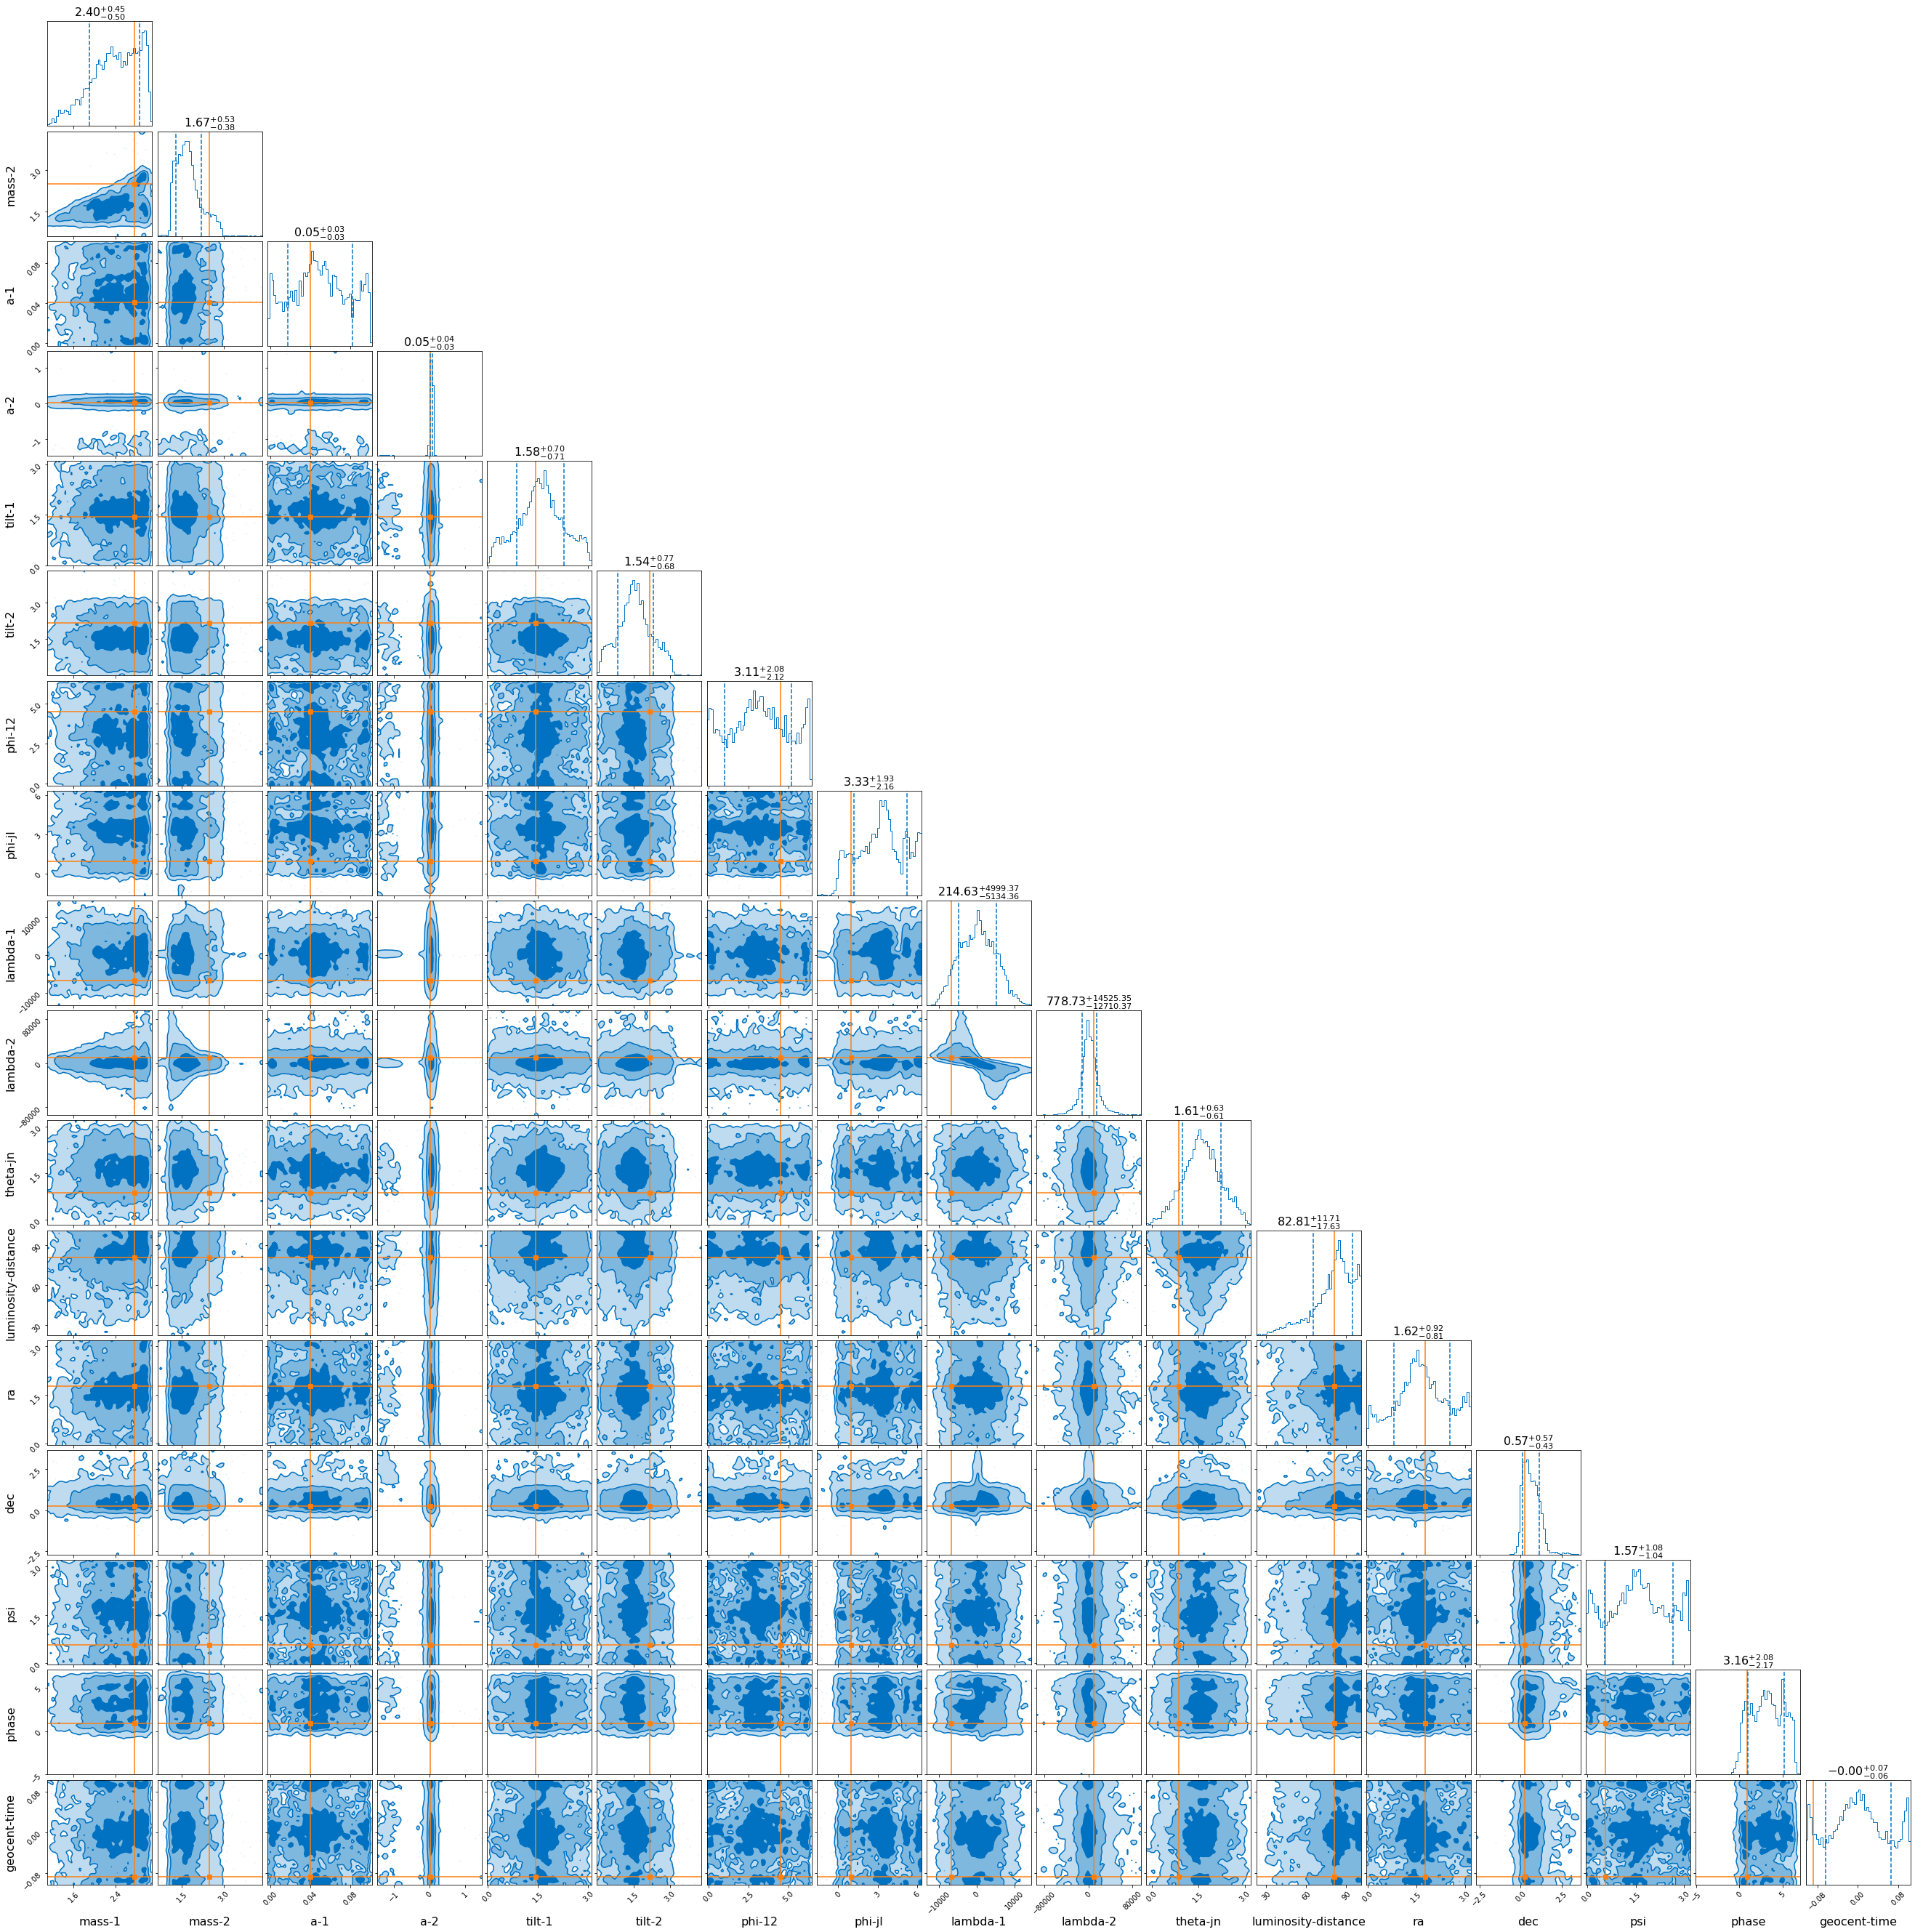

In [92]:
fig = result.plot_corner(parameters=result.injection_parameters, save=False)